In [6]:
#У нас есть данные о связи lncRNA с участками генома - их можно проассоциировать с генами
#У фантома есть даные о дифф экспрессии генов после нокаута lncRNA - как бы эта РНК регулирует эти гены
#Или надо отобрать те гены, которые начали экспрессироваться после нокаута lncRNA?
# Что мы можем сделать?
#Мы должны взять из фантомных данных список генов, которые диффэкспрессируются у конкретной РНК и сравнить его
#с нашим списком генов для этой РНК - по идее они должны сильно пересекаться

In [7]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
# !pip install statsmodels
# !pip install bcbio-gff
# !pip install mygene
# !pip install h5py
# !pip install seaborn

In [1]:
import pandas as pd
import pickle
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

from BCBio import GFF
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
import mygene
import h5py

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

In [2]:
targets = [("H3K27ac", "_narrow"), ("H3K36me3", ""), 
           ("H3K4me1", "_narrow"), ("H3K4me2", "_narrow"), ("H3K4me3", "_narrow"), ("H3K79me2", ""), 
           ("H3K9ac", "_narrow"), ("H3K9me3", ""), ("H4K20me1", ""), ("H3K27me3", ""), ("methylation", "")]

In [3]:
#Строим таблицу, где строки это все возможные lnc, для которых есть хотя бы одно значимое пересечение хотя бы для одной метки
#а столбцы мультииндекс по метке и по типу
def getTableForAllMarks(iMARGI=False, annotation_prefix=""):
    g_annotation_prefix = annotation_prefix + "_" if annotation_prefix else ""
    annotation_prefix = "_" + annotation_prefix if annotation_prefix else ""
    
    df_first = pd.read_csv("../data/all_marks/" + targets[0][0] + "/our_fantom" + annotation_prefix + "_genes_association_pvalues.tsv", sep="\t")
    df_first['lncRNAName'] = ["_".join([name] + i.split('_')[1:]) for i, name in zip(df_first['lncRNAId'], df_first['lncRNAName'])]
    if(iMARGI):
        g = pd.read_csv("../data/all_marks/" + targets[0][0] + "/" + g_annotation_prefix + "genometric_result_all_rnas.tsv", sep="\t")
        df_first = df_first[df_first['lncRNAId'].isin(g['lnc'])][['lncRNAName', 'pm_pvalue', 'mm_pvalue', 'pp_pvalue', 'mp_pvalue']]
    else:
        df_first = df_first[['lncRNAName', 'pm_pvalue', 'mm_pvalue', 'pp_pvalue', 'mp_pvalue']]
        
    for i in range(1, len(targets)):
        df_second = pd.read_csv("../data/all_marks/" + targets[i][0] + "/our_fantom" + annotation_prefix + "_genes_association_pvalues.tsv", sep="\t")
        df_second['lncRNAName'] = ["_".join([name] + i.split('_')[1:]) for i, name in zip(df_second['lncRNAId'], df_second['lncRNAName'])]
        if(iMARGI):
            g = pd.read_csv("../data/all_marks/" + targets[i][0] + "/" + g_annotation_prefix + "genometric_result_all_rnas.tsv", sep="\t")
            df_second = df_second[df_second['lncRNAId'].isin(g['lnc'])][['lncRNAName', 'pm_pvalue', 'mm_pvalue', 'pp_pvalue', 'mp_pvalue']]
        else:
            df_second = df_second[['lncRNAName', 'pm_pvalue', 'mm_pvalue', 'pp_pvalue', 'mp_pvalue']]
            
        df_first = df_first.merge(df_second, how="outer", left_on='lncRNAName', right_on='lncRNAName')
    
    df_first = df_first.set_index('lncRNAName')
    # del df_first.index.name
    df_first = df_first.applymap(lambda x: 0 if np.isnan(x) else -np.log10(x))
    columns_index_1 = ["H3K27ac", "H3K36me3", "H3K4me1", "H3K4me2", "H3K4me3", "H3K79me2", "H3K9ac", "H3K9me3", "H4K20me1", "H3K27me3", "Methylation"]
    columns_index_2 = ['wa', 'ea', 'wr', 'er']
    df_first.columns = pd.MultiIndex.from_product([columns_index_1, columns_index_2], names=['target', 'type'])
    
    np.unravel_index(np.argmax(df_first.values, axis=None), df_first.values.shape)
    
    #df_first = df_first.drop('EMX2OS')
    
    return df_first

In [4]:
def getDataWithoutASOs(iMARGI=False, clusters=False):
    df = getTableForAllMarks(iMARGI=iMARGI, annotation_prefix="fantom_aso")
    df = df.mask(df < 1.3, 0)
    df['geneName'] = [i.split('_')[0] for i in df.index]
    b = df.groupby(['geneName']).apply(check_asos)
    b = b.drop(['geneName'], axis=1)
    b = b[b.astype(bool).sum(axis=1) > 0]
    if clusters:
        return b.apply(add_cluster, axis = 1, result_type="expand")
    else:
        return b

In [5]:
def check_asos(df):
    count = pd.DataFrame({"nonzero_count" : df.astype(bool).sum(axis=0)})['nonzero_count']
    if df.shape[0] == 1:  # Нет нескольких ASO - 1
        return count
    else:
        s = pd.Series([2 if b else 0 for b in count > df.shape[0]/2], index=count.index)
        return s

In [36]:
df1 = getDataWithoutASOs(iMARGI=True)
df1[df1 > 0] = 1
df2 = getDataWithoutASOs(iMARGI=False)
df2[df2 > 0] = 1
df1['sum'] = df1.sum(axis=1)
series2 = df2.sum(axis=1)
df2['sum'] = df2.sum(axis=1)
sum_all = pd.DataFrame({"gene": df1.index, "TRUE": df1['sum']})
sum_all["FALSE"] = 0
i = 0
for row in sum_all.iterrows():
    if row[0] in set(series2.index):
        sum_all.iloc[i,2] = series2[(row[0])]
    else: sum_all.iloc[i,2] = 0
    i+=1
    

,gene,TRUE,FALSE
geneName,,,
A1BG-AS1,A1BG-AS1,1,4
AC005592.2,AC005592.2,1,2
AC007879.7,AC007879.7,1,6
AC016747.3,AC016747.3,1,7
BOLA3-AS1,BOLA3-AS1,1,1
CD27-AS1,CD27-AS1,3,3
CTD-2587H24.5,CTD-2587H24.5,1,1
DNM3OS,DNM3OS,6,10
EMX2OS,EMX2OS,1,1


In [42]:
df1 = getTableForAllMarks(iMARGI=True, annotation_prefix="fantom_aso")
df1[df1 > 0] = 1
df1['sum'] = df1.sum(axis=1)
df2 = getTableForAllMarks(iMARGI=False, annotation_prefix="fantom_aso")
df2[df2 > 0] = 1
df2['sum'] = df2.sum(axis=1)
series2 = df2.sum(axis=1)
sum_all = pd.DataFrame({"gene": df1.index, "TRUE": df1['sum'].astype(int)})
sum_all["FALSE"] = 0
i = 0
for row in sum_all.iterrows():
    if row[0] in set(series2.index):
        sum_all.iloc[i,2] = series2[(row[0])]
    else: sum_all.iloc[i,2] = 0
    i+=1
sum_all = sum_all.reset_index()
sum_all[['RNA','ASO', 'G', 'number', 'smth']] = sum_all['lncRNAName'].str.split('_',expand=True)
sum_all=sum_all[['gene', 'TRUE', 'FALSE', 'RNA']]
sum_all

,gene,TRUE,FALSE,RNA
0,TMCC1-AS1_ASO_G0271270_09,7,14,TMCC1-AS1
1,MEG3_ASO_G0214548_01,10,20,MEG3
2,LINC00968_ASO_G0246430_03,4,12,LINC00968
3,RP11-398K22.12_ASO_G0229852_05,2,4,RP11-398K22.12
4,MAPKAPK5-AS1_ASO_G0234608_06,2,30,MAPKAPK5-AS1
5,RP11-395B7.4_ASO_G0227053_03,4,20,RP11-395B7.4
6,RP11-398K22.12_ASO_G0229852_03,4,8,RP11-398K22.12
7,MAGI2-AS3_ASO_G0234456_04,4,8,MAGI2-AS3
8,LINC00657_ASO_G0260032_AD_06,3,6,LINC00657
9,DNM3OS_ASO_G0230630_AD_04,12,36,DNM3OS


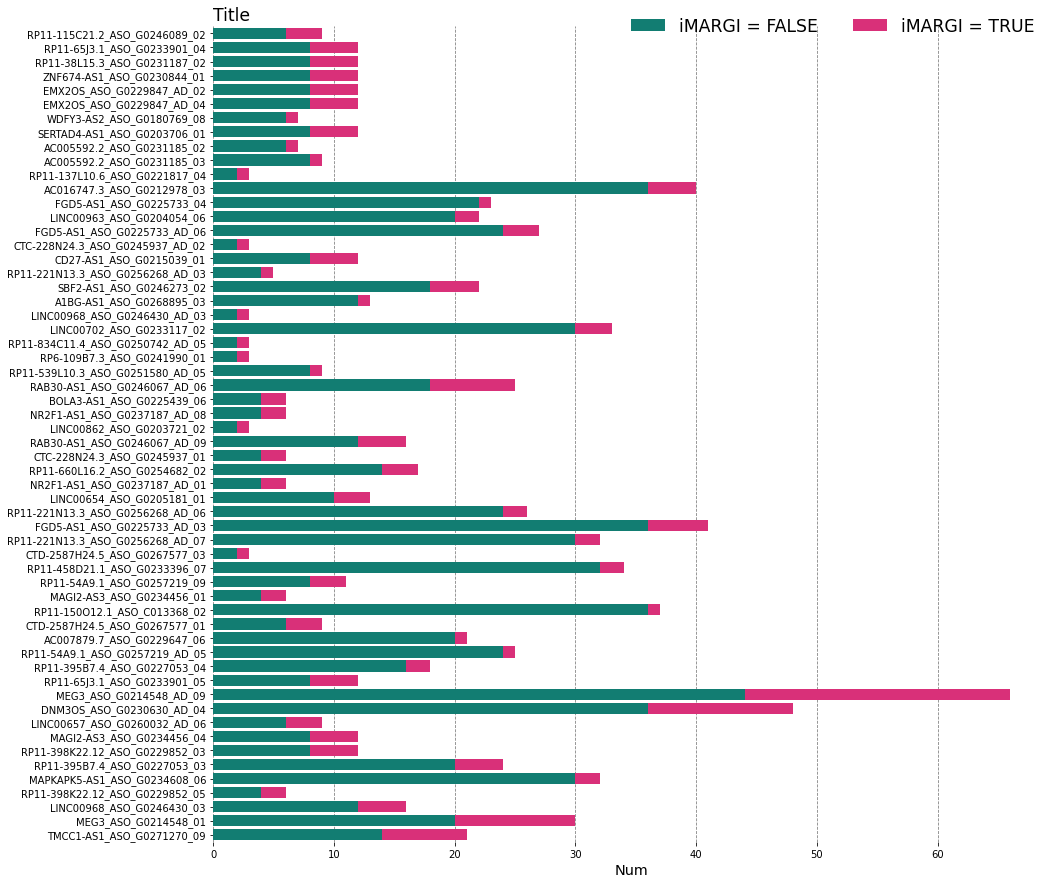

In [43]:
fields = ['FALSE', 'TRUE']
colors = ["#127d72", "#d93079"]
labels = ['iMARGI = FALSE', 'iMARGI = TRUE']# figure and axis
fig, ax = plt.subplots(1, figsize=(15, 15))# plot bars
left = len(sum_all) * [0]
for idx, name in enumerate(fields):
    plt.barh(sum_all['gene'], sum_all[name], left = left, color=colors[idx])
    left = left + sum_all[name]# title, legend, labels
plt.title('Title', loc='left', fontsize='xx-large')
plt.legend(labels, loc='upper right', bbox_to_anchor=(0.5, 0.53, 0.5, 0.5), ncol=2, fontsize='xx-large', frameon=False)
plt.xlabel('Num', fontsize='x-large')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

In [7]:
sum_df2 = pd.DataFrame({"gene": series2.index, "FALSE": series2.values})
sum_df1['iMARGI']='true'
sum_df2['iMARGI']='false'
sum_all = pd.concat([sum_df1, sum_df2])
series2["A1BG-AS1"]


NameError: name 'sum_df1' is not defined

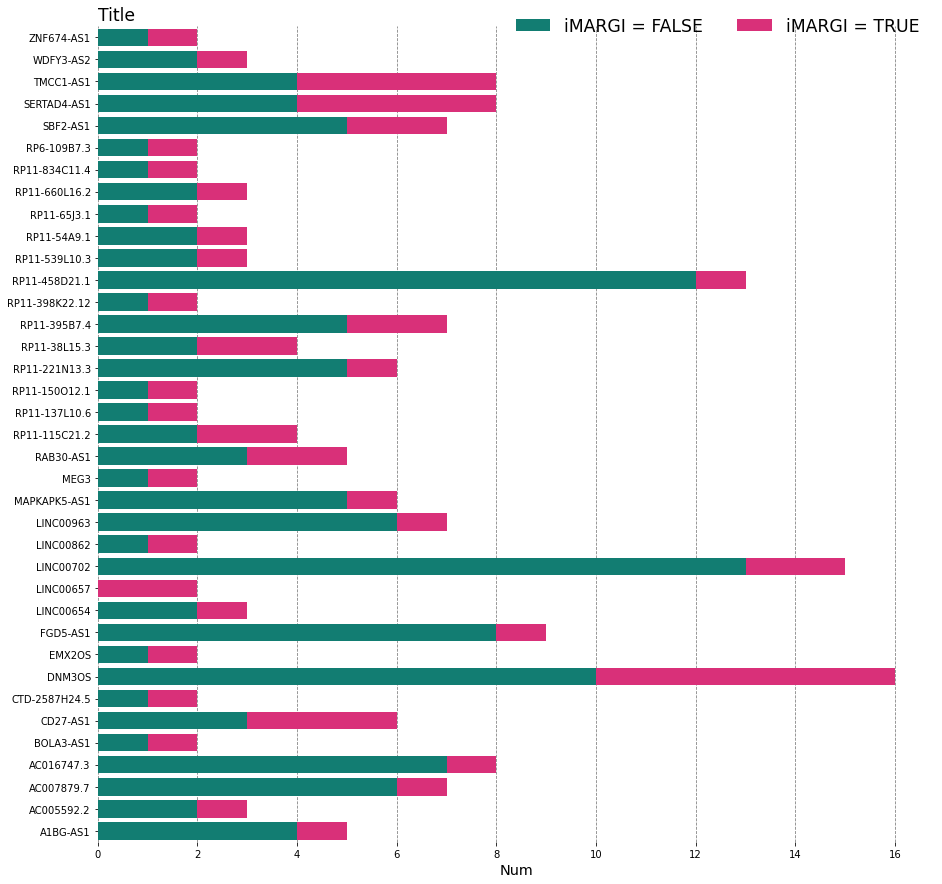

In [15]:
fields = ['FALSE', 'TRUE']
colors = ["#127d72", "#d93079"]
labels = ['iMARGI = FALSE', 'iMARGI = TRUE']# figure and axis
fig, ax = plt.subplots(1, figsize=(15, 15))# plot bars
left = len(sum_all) * [0]
for idx, name in enumerate(fields):
    plt.barh(sum_all['gene'], sum_all[name], left = left, color=colors[idx])
    left = left + sum_all[name]# title, legend, labels
plt.title('Title', loc='left', fontsize='xx-large')
plt.legend(labels, loc='upper right', bbox_to_anchor=(0.5, 0.53, 0.5, 0.5), ncol=2, fontsize='xx-large', frameon=False)
plt.xlabel('Num', fontsize='x-large')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

In [16]:
fig = ax.get_figure()
#fig.patch.set_alpha(0)
fig.savefig("../images/barplot.png", bbox_inches='tight', pad_inches =0)